# Inventory Optimization and Demand Forecasting

#### Optimize inventory management by identifying the product categories (clustering as an outcome of text processing) on the customer review data. Predict what kind of products could be in demand (Time Series Analysis).

## LIBRARIES

#### Data wraggling

In [2]:
import pandas as pd
import numpy as np
import polars
import re
import spacy
from nlppreprocess import NLP
nlp = spacy.load('en_core_web_sm')
import mysql.connector as sql
from  sqlalchemy import create_engine
db=sql.connect(user='root',host='localhost',password='avi101109',database='capstone')
mycursor=db.cursor()
engine=create_engine(f"mysql+pymysql://{'root'}:{'avi101109'}@{'localhost'}/{'capstone'}")

#### Data visualization

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from matplotlib import rcParams
rcParams['figure.figsize']=(12,7)

#### Machine Learning

In [4]:
import mysql.connector as sql
import pandas as pd
from textblob import TextBlob
from afinn import Afinn
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#### NLP

In [5]:
from textblob import TextBlob
from afinn import Afinn
import torch
from transformers import BertTokenizer, BertForSequenceClassification

#### Time Series

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.api import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa import statespace
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from itertools import product
from tqdm import tqdm_notebook

## USER DEFINE FUNCTION

#### Cleaning

In [7]:
def clean(text):
    text=re.sub(r'https?://\S+|www\.\S+','',str(text))
    text=re.sub(r'<.*?>','',text)
    text=re.sub('\n', ' ', text)
    text=re.sub('\\n', ' ', text)
    text=re.sub('\t', ' ', text)
    #text=re.sub(r'[a-bA-b]+\d+\w+', ' ', text)
    text=re.sub(r'\\n(\\t)+<\w+\s\S+\s\S+', '', text)
    text=re.sub(r'\s+', ' ', text)
    return text

#### Lemmatization

In [8]:
def lem(text):
    R1_doc=nlp(text)
    return " ".join(token.lemma_ for token in R1_doc)

#### Stopwords

In [9]:
nlpp=NLP(remove_stopwords= True,
    replace_words = True,
    remove_numbers = True,
    remove_html_tags = True,
    remove_punctuations = True)

#### Textblob

In [10]:
def analyze_sentiment(review):
    testimonial = TextBlob(review)
    polarity = testimonial.sentiment.polarity
    subjectivity = testimonial.sentiment.subjectivity

    if polarity > 0.1:
        return 'positive'
    elif polarity < -0.1:
        return 'negative'
    elif polarity >= -0.1 and polarity <= 0.1:
        if subjectivity >= 0.5:
            return 'conflicted'
        else:
            return 'neutral'

#### Afinn

In [11]:
afinn = Afinn()

# Classify the sentiment of each text as positive, negative, neutral, or mixed
def get_sentiment_category(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    elif score==0:
        return 'Neutral'

#### Bert

In [12]:
# Load the pre-trained BERT model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define a function to perform sentiment analysis using BERT
def bert_sentiment_analysis(text):
    # Tokenize the text
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    # Limit the input length to 512 tokens
    if len(input_ids) > 512:
        input_ids = input_ids[:512]
    # Convert the input to a PyTorch tensor
    input_tensor = torch.tensor(input_ids).unsqueeze(0)
    # Set the model to evaluation mode
    model.eval()
    # Perform the forward pass
    with torch.no_grad():
        outputs = model(input_tensor)
        logits = outputs[0]
    # Get the predicted label
    label = torch.argmax(logits, dim=1).item()
    # Return the label as a string
    if label == 0:
        return "Negative"
    elif label == 1:
        return "Negative"
    elif label == 2:
        return "Neutral"
    elif label == 3:
        return "Mixed"
    elif label == 4:
        return "Positive"
    elif label == 5:
        return "Positive"

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

#### Checking stationarity(TSA)

In [13]:
def checkstat(data):
    movingAverage = data.rolling(window=12).mean()
    movingSTD = data.rolling(window=12).std()
    #Plot rolling statistics: 
    orig =plt.plot(data, color='blue',label='Original') 
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean') 
    std =plt.plot(movingSTD, color='black', label = 'Rolling Std')
    plt. legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    pvalue=adfuller(data)[1]
    if pvalue<.05:
        msg =  "pvalue={}. Data is Stationary. Proceed to model building".format(pvalue)
    else:
        msg = "pvalue={}. Data is not Stationary. Make the data stationary before model building".format(pvalue)
    return msg

#### performance check

In [14]:
def LJUNGBOX(mod):
    pvalue = acorr_ljungbox(mod.resid,lags=[1],return_df=True)['lb_pvalue'].values
    print(pvalue)
    
    if(pvalue<0.05):
        print('Reject H0 , Bad model')
    else:
        print('Failure to reject H0,Good model')

#### Forcasting and predicting

In [15]:
def forecasting(data,p,d,q,P,D,Q,start,end):
    model_fit = SARIMAX(data,order=(p,d,q),seasonal_order=(P,D,Q,12)).fit()
    fig,ax=plt.subplots(1,2,figsize=(22,7))
    pd.concat([data.sentiment,model_fit.predict(start=start,end=end)]).plot(ax=ax[0],label='Actual')
    model_fit.predict(start=start,end=end).plot(ax=ax[0],label='prediction')
    ax[0].legend()
    
    print(model_fit.aic)
    pd.concat([data.sentiment,model_fit.forecast(50)],axis=0).plot(label='Actual',ax=ax[1])
    model_fit.forecast(50).plot(label='forecasted')
    ax[1].legend()
    print(model_fit.aic)
    return LJUNGBOX(model_fit)

In [16]:
def errorcheck(pred):    
    actual = []; p = []
    for i in range(len(pred)):
        actual.append(test.Sales[i])
        p.append(pred[i])
    df = pd.DataFrame({'actual':actual,'predicted':p})
    df['error'] = df.actual-df.predicted
    mse = mean_squared_error(df.actual,df.predicted)
    rmse = mean_squared_error(df.actual,df.predicted,squared=False)
    
    
    fig,ax = plt.subplots(1,2,figsize=(15,6))
    #plotting
    ax[0].plot(df.error)
    ax[0].set_title('Error plot')
    
    #plotting actual & predicted
    ax[1].plot(df.actual)
    ax[1].plot(df.predicted)
    ax[1].set_title('ACTUAL vs PREDiCTED')
    plt.show()
    
    return df,mse,rmse

#### Hypertuning SARIMA(TSA)

In [17]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

# Preprocessing

### Video Games

In [ ]:
vg_m=polars.read_ndjson('/Users/abhishekjanjal/Capstone_Project/Data/meta_Video_Games.json').to_pandas()
vg_r=polars.read_ndjson('/Users/abhishekjanjal/Capstone_Project/Data/Video_Games.json').to_pandas()

In [ ]:
vg_m.drop(['tech1','fit','tech2','similar_item','imageURL','date','price','imageURLHighRes','also_view','also_buy','description','feature','rank'],axis=1,inplace=True)
vg_r.drop(['vote','summary','verified','unixReviewTime'],axis=1,inplace=True)

In [ ]:
vg_r.drop(vg_r[vg_r.reviewerName.isna()].index,axis=0,inplace=True)
vg_r.drop(vg_r[vg_r.reviewText.isna()].index,axis=0,inplace=True)

In [ ]:
vg=vg_r.merge(vg_m,on='asin')

In [ ]:
vg[vg.reviewTime>'2015']

,overall,reviewTime,reviewerID,asin,reviewerName,reviewText,category,title,brand,main_cat
1162945,5.0,2015-01-02,A2Q6UMBGML63QI,B00KM66UIS,Daniel,It's ok.... Fast delivery!,"[Video Games, Kids & Family, Xbox 360, Games, ...",Pro Evolution Soccer 2015 - Xbox 360,by\n \n Konami,Video Games
1162946,3.0,2015-01-02,A3FTMW94VV6AWV,B007PX6M9S,Edie M,Convenient and right price. The inside pages b...,"[Video Games, Nintendo 3DS & 2DS, Accessories]",Insten 28-in-1 Game Holder Card Case for Ninte...,INSTEN,Computers
1162947,5.0,2015-01-02,A1XNWOV39TF50P,B00GZ1H07Y,Pappy,"nice, maybe not all boards are tops, but I lov...","[Video Games, Kids & Family, PlayStation 4, Ga...",The Pinball Arcade - PlayStation 4,by\n \n Alliance Digital Media,Video Games
1162948,5.0,2015-01-02,A3Q0UI4OVQ8NTV,B00EC6VA9I,Micheal,Happy with the products. My daughter loves it.,"[Video Games, PlayStation 3, </span></span></s...",Disney INFINITY Elsa,by\n \n Disney Infinity,Video Games
1162949,4.0,2015-01-02,A376GUM4DN11Y8,B00NY5YYXM,Jake S.,I really like the sound quality of the headset...,"[Video Games, PlayStation 4, Accessories, Head...",PDP Afterglow Kral PS4 Wireless Headset,by\n \n PDP,Video Games
...,...,...,...,...,...,...,...,...,...,...
2449410,1.0,2018-10-02,AXBO2KGK2B4UP,B01HD1B64C,Kevin,"This game is garbage. Choppy controls, mediocr...","[Video Games, PlayStation 4, Games, </span></s...",Road Rage - PlayStation 4,by\n \n Maximum Games,Video Games
2449411,1.0,2018-10-02,A2RK558THM3K6Y,B01GW8YDLK,cyclonus,Game freezes no matter what i do been trying t...,"[Video Games, PlayStation 4, Games, </span></s...",Marvel&rsquo;s Spider-Man - PlayStation 4,by\n \n Sony,Video Games
2449412,5.0,2018-10-02,A2Q1068OYRHLQE,B01GW3GSVS,Aileen,Stand is great. Does its job and holds Xbox ri...,"[Video Games, Xbox One, Accessories, Accessory...",Xbox One S Vertical Stand,by\n \n Microsoft,Video Games
2449413,1.0,2018-10-02,AI6D5XZOS3L0V,B01H6GUCCQ,Amazon Customer,Stopped working 2 months after having it... no...,"[Video Games, PC, Accessories, Headsets]","BENGOO G9000 Stereo Gaming Headset for PS4, PC...",BENGOO,Computers


In [ ]:
vg.drop(vg[vg['category'].str.len()== 0].index,axis=0,inplace=True)
vg.drop(vg[vg['reviewText']== ''].index,axis=0,inplace=True)
vg.drop(vg[vg['title']== ''].index,axis=0,inplace=True)
vg.drop(vg[vg['brand']== ''].index,axis=0,inplace=True)
vg.drop(vg[vg['main_cat']== ''].index,axis=0,inplace=True)
vg.drop(vg[vg['reviewerName']== ''].index,axis=0,inplace=True)

In [ ]:
vg.drop_duplicates(subset=['asin','reviewerID'],inplace=True)

In [ ]:
vg['reviewTime']=pd.to_datetime(vg.reviewTime,infer_datetime_format=True)

In [ ]:
vg.sort_values('reviewTime',ignore_index=True,inplace=True)

In [ ]:
vg[(vg.reviewTime>'2016-10-02') & (vg.reviewTime < '2017-7') ]

,overall,reviewTime,reviewerID,asin,reviewerName,reviewText,category,title,brand,main_cat
1947662,5.0,2016-10-03,A1K33HYDFCZFR3,B000CSUKZ0,MT,Mint condition! Excellent!,"[Video Games, Retro Gaming & Microconsoles, Pl...",Driver Parallel Lines - PlayStation 2,by\n \n Atari,Video Games
1947663,5.0,2016-10-03,A1Z0WCABRDMJ8A,B00004U8QX,Alpha13,Thank you,"[Video Games, Retro Gaming & Microconsoles, Pl...",Trenro AV to RCA Cable Compatible with Playsta...,Trenro,Computers
1947664,5.0,2016-10-03,A1BCJMBXBLD1D3,B01AC3ZDB0,Kimbery O.,Daughter loves it,"[Video Games, Kids & Family, Wii, Games, </spa...",Nintendo Selects: Animal Crossing: City Folk,by\n \n Nintendo,Video Games
1947665,1.0,2016-10-03,A17LEKGJG7V1WB,B019MFPLC0,KMac,I hate to knock the product as the stick and b...,"[Video Games, PlayStation 3, Accessories, Cont...",Mayflash F300 Arcade Fight Stick Joystick for ...,May Flash,Computers
1947666,5.0,2016-10-03,A26DK3BH8YPM4P,B00HQY9FIG,Lepacol,Really cute case to protect my nintendo.,"[Video Games, Nintendo DS, Accessories, </span...",Official Nintendo Mario Travel Case for Ninten...,by\n \n PowerA,Video Games
...,...,...,...,...,...,...,...,...,...,...
2217037,3.0,2017-06-30,A15HRKPETHMJJX,B002M2N9NO,Amazon Customer,"Game played great, but the case arrived broken...","[Video Games, Retro Gaming & Microconsoles, Pl...",Rock Band,by\n \n MTV Games,Video Games
2217038,5.0,2017-06-30,A3KNQR3EAFGCXK,B016Y3CTJQ,Amazon Customer,"Perfect, just what the Boy wanted","[Video Games, PlayStation 4, Accessories, Batt...","PS4 Controller Charger, Megadream Playstation ...",Megadream,All Electronics
2217039,3.0,2017-06-30,A25X9AIOTYUFQ2,B017XP8NEE,Aryn,Great for casual gaming. Not so great for comp...,"[Video Games, Retro Gaming & Microconsoles, Ga...",Replacement 3D Analog Joystick for NGC GameCub...,Vivi Audio,Computers
2217040,1.0,2017-06-30,A30E9DIIH3EX6B,B00LCHZRIK,Amazon Customer,This was a gift I bought and sent to Bulgaria ...,"[Video Games, Wii U, Games, </span></span></sp...",The Legend of Zelda: Breath of the Wild - Wii U,by\n \n Nintendo,Video Games


In [ ]:
vg[vg.reviewTime>'2015'].to_sql('video_game',engine,index=True)

1286470

In [ ]:
vg_sent=vg.sample(n=50000,random_state=0,ignore_index=0)

In [ ]:
vg_sent['reviewText']=vg_sent['reviewText'].apply(clean)
vg_sent['category']=vg_sent['category'].apply(clean)
vg_sent['brand']=vg_sent['brand'].apply(clean)
vg_sent['main_cat']=vg_sent['main_cat'].apply(clean)

In [ ]:
vg_sent['reviewText']=vg_sent['reviewText'].apply(nlpp.process)
vg_sent['reviewText']=vg_sent['reviewText'].apply(remove_noun)
vg_sent['reviewText']=vg_sent['reviewText'].apply(lem)

In [ ]:
vg_sent.to_sql('video_game_sent',engine,index=False)

50000

## Toys and Games

In [ ]:
tag_m=polars.read_ndjson('/Users/abhishekjanjal/Capstone_Project/Data/meta_Toys_and_Games.json').to_pandas()

In [ ]:
tag_r=polars.read_ndjson('/Users/abhishekjanjal/Capstone_Project/Data/Toys_and_Games.json').to_pandas()

In [ ]:
tag_m.drop(['tech1','fit','tech2','similar_item','imageURL','date','price','imageURLHighRes','also_view','also_buy','description','feature','rank'],axis=1,inplace=True)
tag_r.drop(['vote','image','style','summary','verified','unixReviewTime'],axis=1,inplace=True)

In [ ]:
tag_r.drop(tag_r[tag_r.reviewerName.isna()].index,axis=0,inplace=True)
tag_r.drop(tag_r[tag_r.reviewText.isna()].index,axis=0,inplace=True)

In [ ]:
tag=tag_r.merge(tag_m,on='asin')

In [ ]:
tag.drop(tag[tag['category'].str.len()== 0].index,axis=0,inplace=True)
tag.drop(tag[tag['reviewText']== ''].index,axis=0,inplace=True)
tag.drop(tag[tag['title']== ''].index,axis=0,inplace=True)
tag.drop(tag[tag['brand']== ''].index,axis=0,inplace=True)
tag.drop(tag[tag['main_cat']== ''].index,axis=0,inplace=True)
tag.drop(tag[tag['reviewerName']== ''].index,axis=0,inplace=True)

In [ ]:
tag.drop_duplicates(subset=['asin','reviewerID'],inplace=True)

In [ ]:
tag['reviewTime']=pd.to_datetime(tag.reviewTime,infer_datetime_format=True)

In [ ]:
tag.sort_values('reviewTime',ignore_index=True,inplace=True)

In [ ]:
tag.shape

(7402466, 10)

In [ ]:
tag[tag.reviewTime>'2015'].to_sql('Toy_game',engine,index=True)

5242918

In [ ]:
tag_sent=tag.sample(n=50000,random_state=0,ignore_index=0)

In [ ]:
tag_sent.head()

,overall,reviewTime,reviewerID,asin,reviewerName,reviewText,category,title,brand,main_cat
3412401,5.0,2015-11-03,A23F2LELNDSB0P,B00YXNW3DC,owalt,Bought as a X-Mas gift,['Toys & Games' 'Games' 'Board Games'],Crafts'man Wooden Solitaire Puzzles Game with ...,Crafts'man,Toys & Games
2226587,4.0,2015-01-08,AA5D062V6ADVZ,B00HWMY8XY,mgh2568,As pictured.,['Toys & Games' 'Building Toys' 'Building Sets'],LEGO Star Wars 75040 General Grievous' Wheel B...,LEGO,Toys & Games
4058586,5.0,2016-02-29,A2LD3CX8HFJT9G,B00B0QC42U,Amazon Customer,"The order came about a month early, which was ...",['Toys & Games' 'Action Figures & Statues' 'Ac...,Chara Heroes - Berserk: Golden Age (15pcs) by ...,Toki-Meki,Toys & Games
4744085,1.0,2016-08-08,A2WM1SFIBUCS6,B019HZ2A24,Amazon Customer,I thought this was more of a pillow than it is...,['Toys & Games' 'Stuffed Animals & Plush Toys'...,YINGGG Cute Emoji Plush Pillow Heart Shape Cus...,YINGGG,Toys & Games
594961,3.0,2012-12-26,A2N48XBUS9YDMP,B0042ESFQQ,Sjmissy,This is a cute Ken doll but... OURS doesn't wo...,['Toys & Games' 'Dolls & Accessories' 'Dolls'],Barbie Shaving Fun Ken Doll,Barbie,Toys & Games


In [ ]:
tag_sent['reviewText']=tag_sent['reviewText'].apply(clean)
tag_sent['category']=tag_sent['category'].apply(clean)
tag_sent['brand']=tag_sent['brand'].apply(clean)
tag_sent['main_cat']=tag_sent['main_cat'].apply(clean)

In [ ]:
tag_sent['reviewText']=tag_sent['reviewText'].apply(nlpp.process)
tag_sent['reviewText']=tag_sent['reviewText'].apply(remove_noun)
tag_sent['reviewText']=tag_sent['reviewText'].apply(lem)

In [ ]:
tag_sent.to_sql('toy_game_sent',engine,index=False)

50000

# Sentiment Analysic

### Video Game

In [ ]:
vg=pd.read_sql('select * from video_game_sent',con=db)

In [ ]:
vg.to_csv('video_sent.csv')

In [ ]:
vg['Textblob']=vg.reviewText.apply(analyze_sentiment)

In [ ]:
vg['afinn_score'] = vg['reviewText'].apply(lambda text: afinn.score(text))
vg['affin']=vg.afinn_score.apply(get_sentiment_category)

In [ ]:
y=vg['Sentiment']
x=vg[['reviewText']]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [ ]:
cnt=CountVectorizer(binary=True,ngram_range=(1, 3))
lr=LogisticRegression(multi_class='multinomial',solver='lbfgs',C=1)
trans=ColumnTransformer([('encode',cnt,'reviewText')],remainder='passthrough')

In [ ]:
pipe.fit(x_train,y_train)
y_pred=pipe.predict(x_test)


KeyboardInterrupt: 

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')

In [ ]:
import pickle
file = open('Logistic_Regression.pkl','wb') ## storing ML model
pickle.dump(pipe,file)

# Demand Forecasting

## Video_Game

In [ ]:
db=sql.connect(user='root',password='avi101109',host='localhost',database='capstone')

In [ ]:
vg_tsa=pd.read_sql('select Sentiment,reviewTime,reviewText,title from video_game',con=db)

/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [ ]:
from textblob import TextBlob

In [ ]:
def get_sentiment(text):
    """
    Takes a string of text and returns the polarity and sentiment label using TextBlob library
    """
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    
    if polarity > 0:
        return 'positive'
    elif polarity == 0:
        return 'neutral'
    else:
        return 'negative'

def add_sentiment(df, text_column):
    """
    Takes a dataframe and a column containing text, and adds two new columns for sentiment and polarity
    """
    df['sentiment'] = df[text_column].apply(get_sentiment)
    df['polarity'] = df[text_column].apply(lambda x: TextBlob(x).sentiment.polarity)
    
    return df

In [ ]:
add_sentiment(vg_tsa,'reviewText')

,Sentiment,reviewTime,reviewText,title,sentiment,polarity
0,Positive,2015-01-02,It's ok.... Fast delivery!,Pro Evolution Soccer 2015 - Xbox 360,positive,0.375000
1,Neutral,2015-01-02,Convenient and right price. The inside pages b...,Insten 28-in-1 Game Holder Card Case for Ninte...,positive,0.223810
2,Positive,2015-01-02,"nice, maybe not all boards are tops, but I lov...",The Pinball Arcade - PlayStation 4,positive,0.283333
3,Positive,2015-01-02,Happy with the products. My daughter loves it.,Disney INFINITY Elsa,positive,0.800000
4,Positive,2015-01-02,I really like the sound quality of the headset...,PDP Afterglow Kral PS4 Wireless Headset,positive,0.198393
...,...,...,...,...,...,...
1286465,Negative,2018-10-02,"This game is garbage. Choppy controls, mediocr...",Road Rage - PlayStation 4,negative,-0.070238
1286466,Negative,2018-10-02,Game freezes no matter what i do been trying t...,Marvel&rsquo;s Spider-Man - PlayStation 4,negative,-0.400000
1286467,Positive,2018-10-02,Stand is great. Does its job and holds Xbox ri...,Xbox One S Vertical Stand,positive,0.542857
1286468,Negative,2018-10-02,Stopped working 2 months after having it... no...,"BENGOO G9000 Stereo Gaming Headset for PS4, PC...",neutral,0.000000


In [ ]:
vg_tsa['reviewTime']=pd.to_datetime(vg_tsa.reviewTime,infer_datetime_format=True)

In [ ]:
vg_tsa.set_index('reviewTime',inplace=True)
vg_tsa.sort_index(inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()
vg_tsa['sentiment'] =le.fit_transform(vg_tsa['sentiment'])
vg_tsa.head()

,Sentiment,reviewText,title,sentiment,polarity
reviewTime,,,,,
2015-01-02,Positive,It's ok.... Fast delivery!,Pro Evolution Soccer 2015 - Xbox 360,2,0.375000
2015-01-02,Neutral,Convenient and right price. The inside pages b...,Insten 28-in-1 Game Holder Card Case for Ninte...,2,0.223810
2015-01-02,Positive,"nice, maybe not all boards are tops, but I lov...",The Pinball Arcade - PlayStation 4,2,0.283333
2015-01-02,Positive,Happy with the products. My daughter loves it.,Disney INFINITY Elsa,2,0.800000
2015-01-02,Positive,I really like the sound quality of the headset...,PDP Afterglow Kral PS4 Wireless Headset,2,0.198393


In [ ]:
positive = vg_tsa[['polarity']][vg_tsa.polarity>0]
negative = vg_tsa[['polarity']][vg_tsa.polarity<0]
pos_vg = positive.resample(rule='MS').mean()
neg_vg= negative.resample(rule='MS').mean()

In [ ]:
pos_vg.drop(pos_vg[pos_vg['polarity'].isnull()].index,axis=0,inplace=True)

In [ ]:
neg_vg.drop(neg_vg[neg_vg['polarity'].isnull()].index,axis=0,inplace=True)

In [ ]:
pos_vg=pos_vg[['polarity']]
neg_vg=neg_vg[['polarity']]

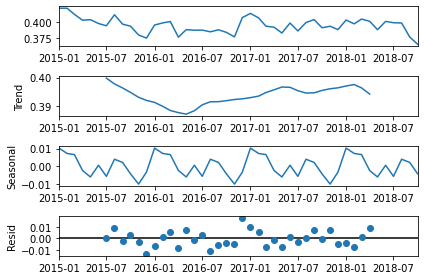

In [ ]:
seasonal_decompose(pos_vg,period=12).plot();

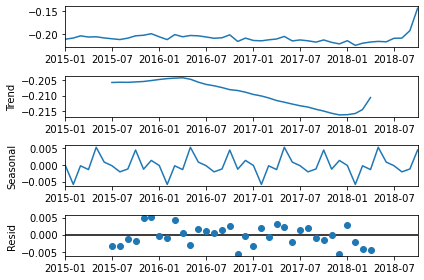

In [ ]:
seasonal_decompose(neg_vg,period=12).plot();

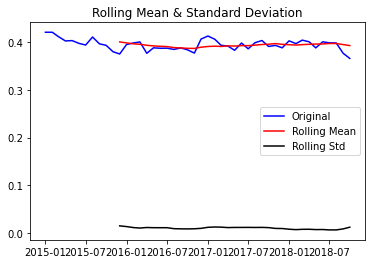

'pvalue=0.0061977250235353745. Data is Stationary. Proceed to model building'

In [ ]:
checkstat(pos_vg)

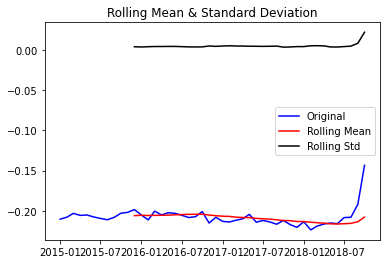

'pvalue=0.3081034236680772. Data is not Stationary. Make the data stationary before model building'

In [ ]:
checkstat(neg_vg)

In [ ]:
p = range(0,12, 2)
d = 1
q = range(0, 12, 2)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 12
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

576


In [ ]:
result_vg = optimize_SARIMA(parameters_list, 1, 1, 4,pos_vg)
result_vg

/var/folders/0k/fvxrc6xx287214q6n9hdy0500000gn/T/ipykernel_1450/3985239075.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(parameters_list):


  0%|          | 0/576 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py

,"(p,q)x(P,Q)",AIC
0,"(4, 0, 0, 1)",-239.081637
1,"(0, 0, 2, 1)",-239.039707
2,"(0, 0, 0, 1)",-239.027875
3,"(0, 0, 0, 3)",-238.942843
4,"(4, 0, 0, 2)",-237.260091
...,...,...
139,"(2, 10, 0, 0)",274.067419
140,"(4, 10, 0, 0)",278.067163
141,"(6, 10, 0, 0)",282.067476
142,"(10, 8, 0, 0)",286.067987


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.06959D+00    |proj g|=  3.66282D+00

At iterate    5    f= -2.07083D+00    |proj g|=  1.68870D+00

At iterate   10    f= -2.12747D+00    |proj g|=  2.50113D+01

At iterate   15    f= -2.17366D+00    |proj g|=  1.06878D+00

At iterate   20    f= -2.17416D+00    |proj g|=  3.77578D-02

At iterate   25    f= -2.17421D+00    |proj g|=  6.72113D-01

At iterate   30    f= -2.17638D+00    |proj g|=  2.16415D-01

At iterate   35    f= -2.17639D+00    |proj g|=  1.78012D-01

At iterate   40    f= -2.17674D+00    |proj g|=  1.18516D+00

At iterate   45    f= -2.17677D+00    |proj g|=  1.19819D-02

At iterate   50    f= -2.17678D+00    |proj g|=  5.04659D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


-188.26361663320813


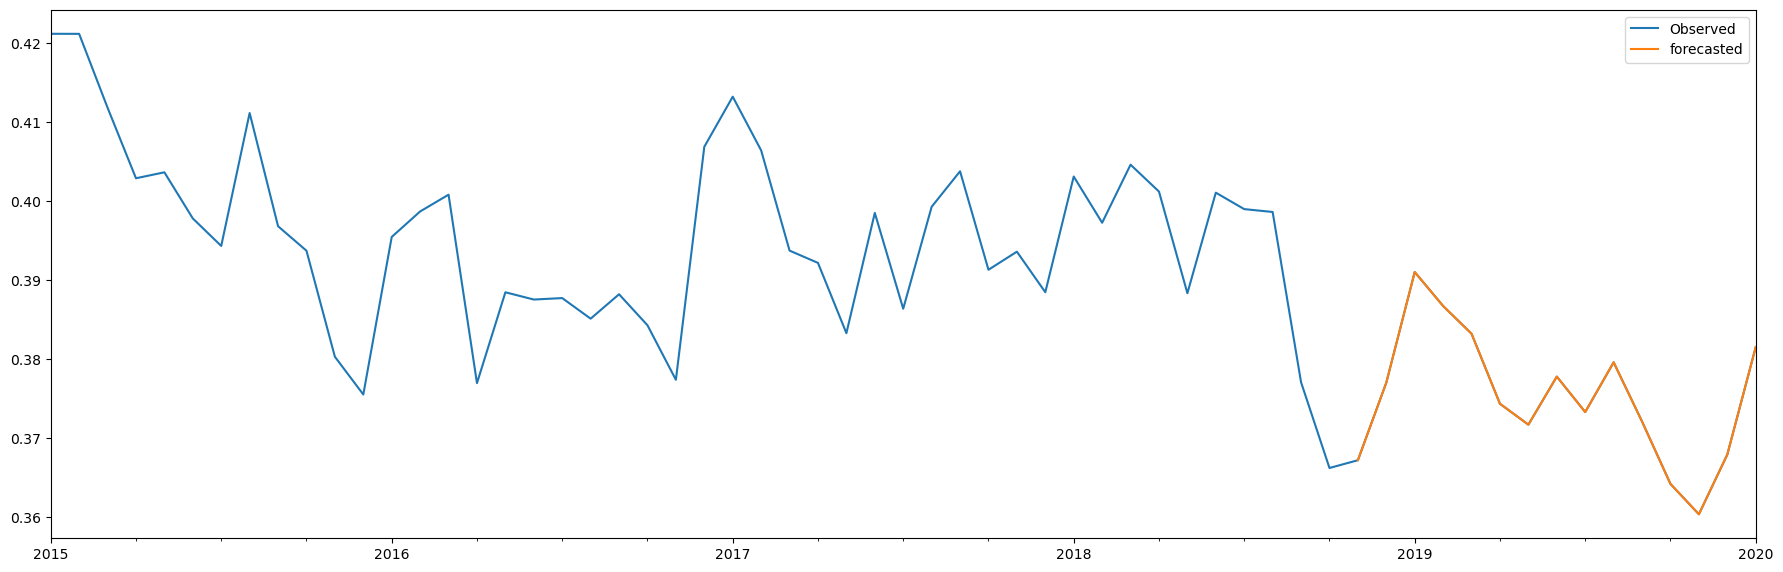

In [ ]:
forecasting(pos_vg,4,1,0,0,1,1,0,46)

In [ ]:
neg_vg['polarity']=neg_vg['polarity']*-1

In [ ]:
neg_vg.shape

(46, 1)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.24510D+00    |proj g|=  3.07053D+01

At iterate    5    f= -2.26562D+00    |proj g|=  3.55711D-01

At iterate   10    f= -2.27437D+00    |proj g|=  4.28793D+00

At iterate   15    f= -2.32483D+00    |proj g|=  1.17719D+00

At iterate   20    f= -2.32962D+00    |proj g|=  9.05357D-01

At iterate   25    f= -2.33659D+00    |proj g|=  1.17899D+00

At iterate   30    f= -2.33678D+00    |proj g|=  2.97972D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


-202.98425356160618
-202.98425356160618


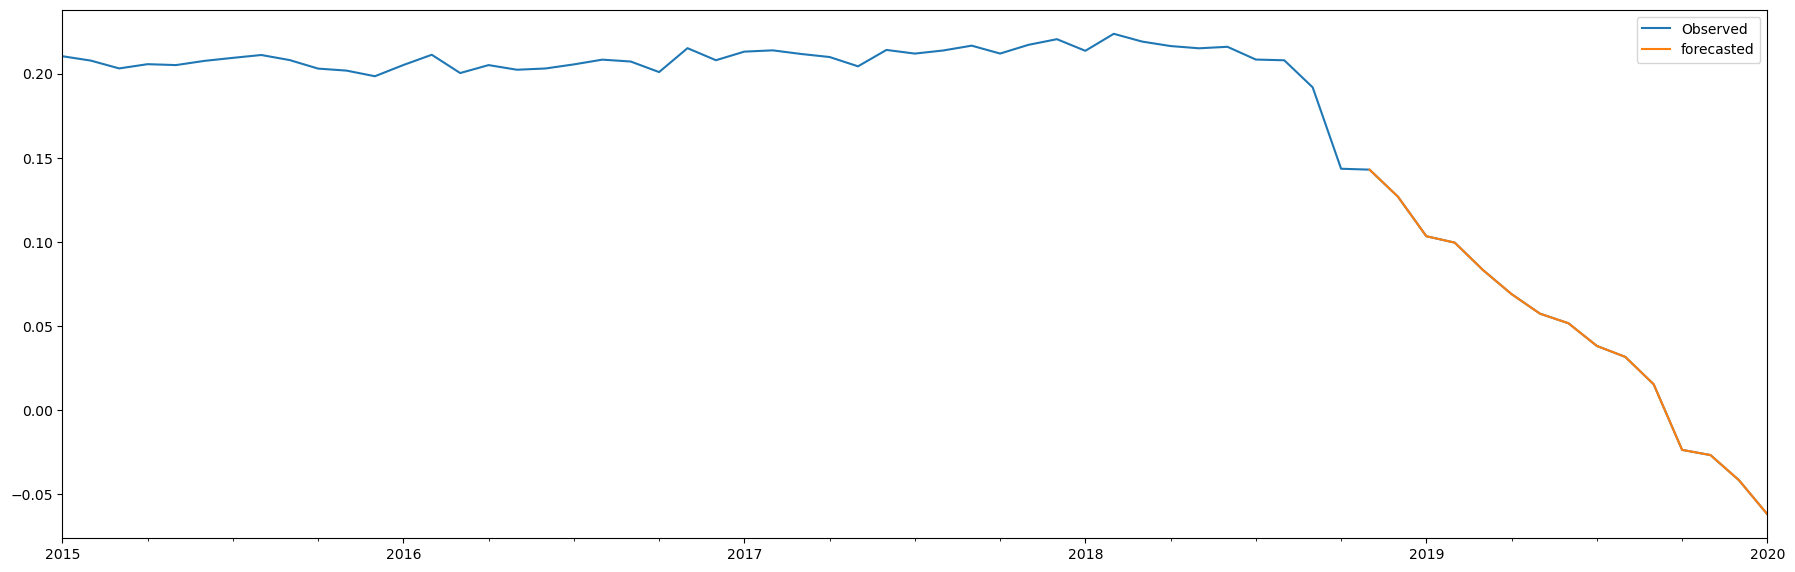

In [ ]:

forecasting(neg_vg,4,1,0,0,1,1,0,46)

## Toy and Game

In [ ]:
tag_tsa=pd.read_sql('select reviewTime,reviewText ,sentiment,asin from toy_game',con=db)

/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [ ]:
add_sentiment(tag_tsa,'reviewText')

,reviewTime,reviewText,sentiment,asin,polarity
0,2015-01-02,Got it for my 2.5 year old nephew. He didn't l...,positive,B00II4XTS0,0.315000
1,2015-01-02,Kids loved it in the tub and on the tile floor...,positive,B00IQ8MVM8,0.493750
2,2015-01-02,Fun little stroller for quick walks around the...,negative,B006LMZY4S,-0.048333
3,2015-01-02,My son love it,positive,B00A8UT562,0.500000
4,2015-01-02,Can't go wrong with a board game. It's unique...,negative,B000HX1NBA,-0.070000
...,...,...,...,...,...
5242913,2018-10-03,One of the straps snapped after only having th...,negative,B01HHTF4KM,-0.100000
5242914,2018-10-04,NiMH has over twice the charge density of NiCd...,positive,B01HJDFWDK,0.600000
5242915,2018-10-04,A few of the cards were not cut right and also...,positive,B01HH1GMPQ,0.031888
5242916,2018-10-05,These LED rings are super easy to put on and w...,positive,B01HISTOC6,0.441667


In [ ]:
tag_tsa['reviewTime']=pd.to_datetime(tag_tsa.reviewTime,infer_datetime_format=True)

In [ ]:
tag_tsa.set_index('reviewTime',inplace=True)
tag_tsa.sort_index(inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()
tag_tsa['sentiment'] =le.fit_transform(tag_tsa['sentiment'])
tag_tsa.head()

,reviewText,sentiment,asin,polarity
reviewTime,,,,
2015-01-02,Got it for my 2.5 year old nephew. He didn't l...,2,B00II4XTS0,0.315000
2015-01-02,Kids loved it in the tub and on the tile floor...,2,B00IQ8MVM8,0.493750
2015-01-02,Fun little stroller for quick walks around the...,0,B006LMZY4S,-0.048333
2015-01-02,My son love it,2,B00A8UT562,0.500000
2015-01-02,Can't go wrong with a board game. It's unique...,0,B000HX1NBA,-0.070000


In [ ]:
positive = tag_tsa[['polarity']][tag_tsa.polarity>0]
negative = tag_tsa[['polarity']][tag_tsa.polarity<0]
pos_tag = positive.resample(rule='MS').mean()
neg_tag= negative.resample(rule='MS').mean()

In [ ]:
pos_tag.drop(pos_tag[pos_tag['polarity'].isnull()].index,axis=0,inplace=True)

In [ ]:
neg_tag.drop(neg_tag[neg_tag['polarity'].isnull()].index,axis=0,inplace=True)

In [ ]:
pos_tag=pos_tag[['polarity']]
neg_tag=neg_tag[['polarity']]

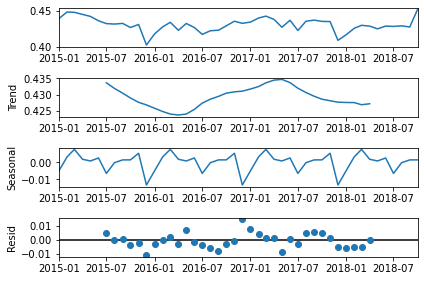

In [ ]:
seasonal_decompose(pos_tag,period=12).plot();

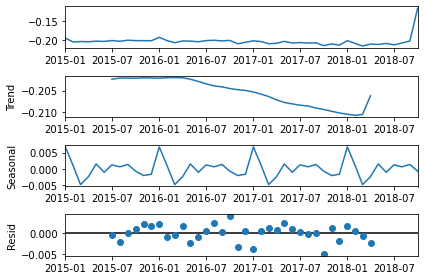

In [ ]:
seasonal_decompose(neg_tag,period=12).plot();

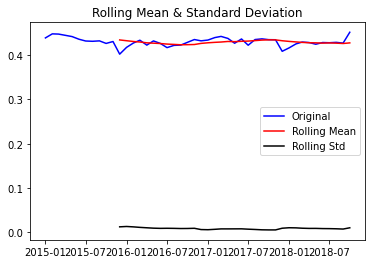

'pvalue=0.00964063092329266. Data is Stationary. Proceed to model building'

In [ ]:
checkstat(pos_tag)

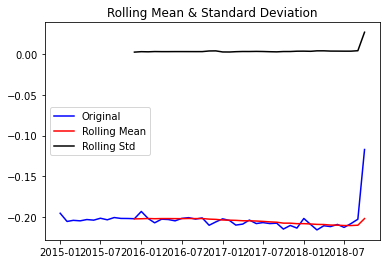

'pvalue=0.4121865200013084. Data is not Stationary. Make the data stationary before model building'

In [ ]:
checkstat(neg_tag)

In [ ]:
p = range(0,12, 2)
d = 1
q = range(0, 12, 2)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 12
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

576


In [ ]:
result_vg = optimize_SARIMA(parameters_list, 1, 1, 4,pos_vg)
result_vg

/var/folders/0k/fvxrc6xx287214q6n9hdy0500000gn/T/ipykernel_1450/3985239075.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(parameters_list):


  0%|          | 0/576 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py

,"(p,q)x(P,Q)",AIC
0,"(4, 0, 0, 1)",-239.081637
1,"(0, 0, 2, 1)",-239.039707
2,"(0, 0, 0, 1)",-239.027875
3,"(0, 0, 0, 3)",-238.942843
4,"(4, 0, 0, 2)",-237.260091
...,...,...
139,"(2, 10, 0, 0)",274.067419
140,"(4, 10, 0, 0)",278.067163
141,"(6, 10, 0, 0)",282.067476
142,"(10, 8, 0, 0)",286.067987


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.26470D+00    |proj g|=  5.18533D+00

At iterate    5    f= -2.26594D+00    |proj g|=  1.01691D+00

At iterate   10    f= -2.36342D+00    |proj g|=  1.17553D+01

At iterate   15    f= -2.36906D+00    |proj g|=  5.27597D+00

At iterate   20    f= -2.37247D+00    |proj g|=  8.97355D-02

At iterate   25    f= -2.38095D+00    |proj g|=  2.82353D-01

At iterate   30    f= -2.38122D+00    |proj g|=  2.02903D-01
  ys=-6.532E-05  -gs= 1.132E-04 BFGS update SKIPPED

At iterate   35    f= -2.38125D+00    |proj g|=  5.00734D-02

At iterate   40    f= -2.38128D+00    |proj g|=  1.06762D-01

At iterate   45    f= -2.38128D+00    |proj g|=  7.72329D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47    135      2     1     0   6.689D-02  -2.381D+00
  F =  -2.3812823379192327     

ABNORMAL_TERMINATION_IN_LNSRCH                              
-207.07797508856942
-207.07797508856942


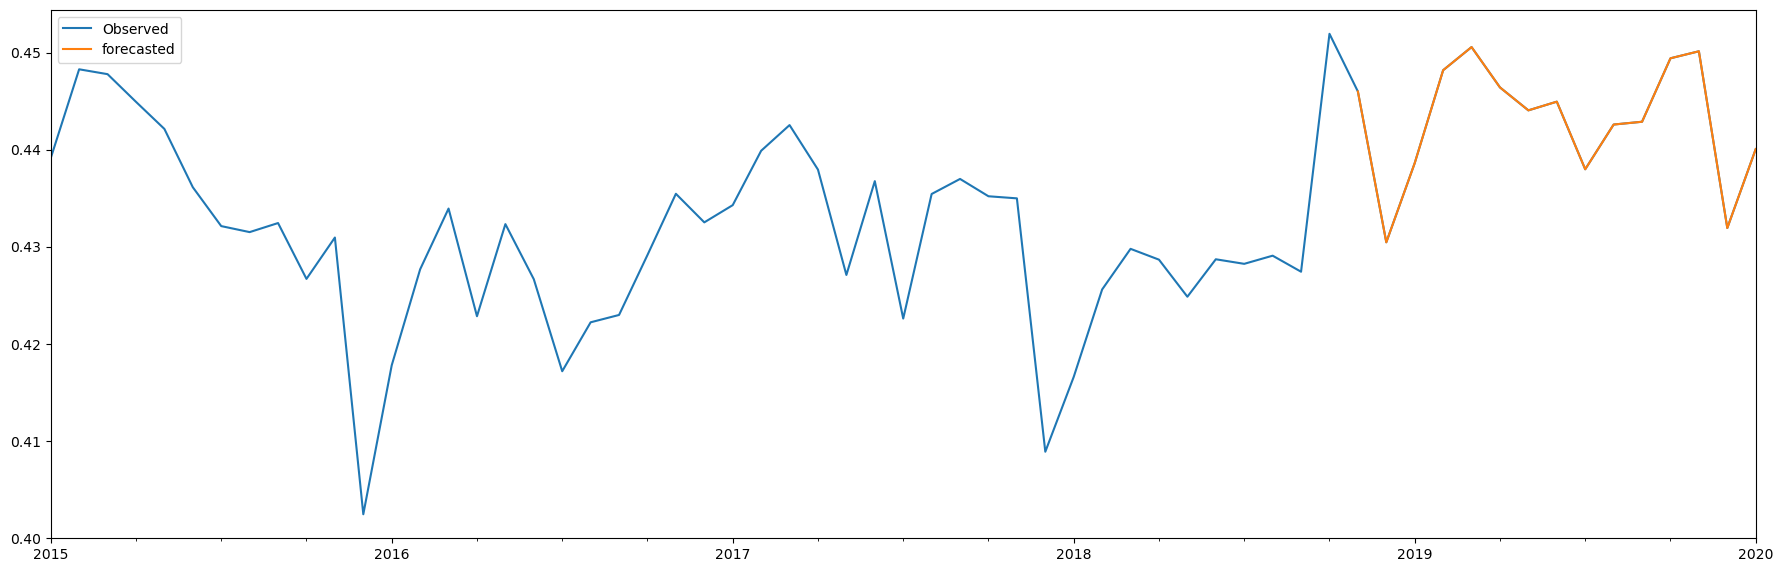

In [ ]:
forecasting(pos_tag,4,1,0,0,1,1,0,46)

In [ ]:
neg_tag['polarity']=neg_tag['polarity']*-1

In [ ]:
neg_vg.shape

(46, 1)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.90189D+00    |proj g|=  4.63352D+00

At iterate    5    f= -1.90383D+00    |proj g|=  5.68166D-01

At iterate   10    f= -1.93045D+00    |proj g|=  1.04196D+01

At iterate   15    f= -1.93830D+00    |proj g|=  3.00602D-02

At iterate   20    f= -1.94015D+00    |proj g|=  1.49746D+00

At iterate   25    f= -1.94221D+00    |proj g|=  1.89282D+00

At iterate   30    f= -1.94313D+00    |proj g|=  1.04827D+00

At iterate   35    f= -1.94445D+00    |proj g|=  8.79851D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39    135      3     0     0   3.315D-02  -1.944D+00
  F =  -1.9444481912854916     

ABNORMAL_TERMINATION_IN_LNSRCH                              
-166.88923359826524
-166.88923359826524


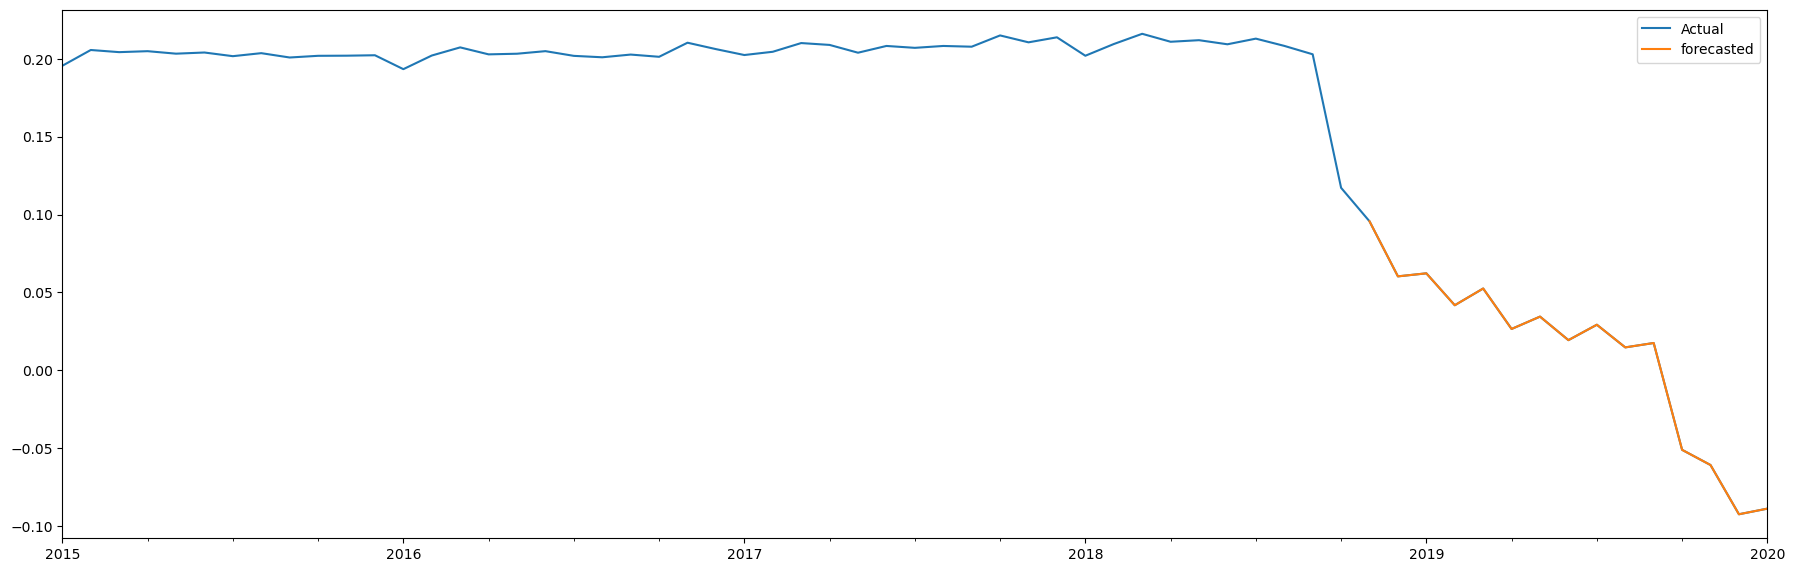

In [ ]:

forecasting(neg_tag,4,1,0,0,1,1,0,46)